# Улучшение модели прогнозирования продаж (Improvements)

## 1: Импорт библиотек и настройка

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import json
import os

# Настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# ML библиотеки
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Модели
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

print("Библиотеки загружены!")

Библиотеки загружены!


## 2: Загрузка данных и Baseline результатов

✓ Обработанные данные загружены. Размер: (421570, 21)

Результаты Baseline:
Лучшая модель: RandomForest
Лучший R2: 0.5131
Лучший MAE: $8431.07
Лучший MSE: 254821343

Статистика целевой переменной:
Mean: $15981.26
Std: $22711.18
Min: $-4988.94
Max: $693099.36
Median: $7612.03
Skewness: 3.26


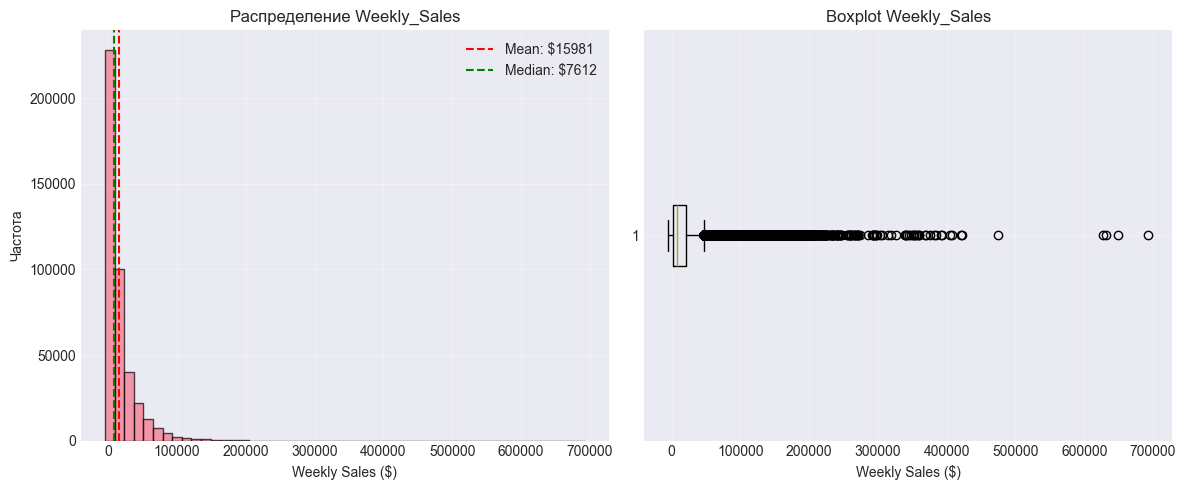


Количество магазинов: 45
Количество департаментов: 81
Период данных: 2010-02-05 - 2012-10-26
Всего недель: 142


In [4]:
# Загрузка обработанных данных из Baseline
processed_data_path = '../data/processed/baseline_data.csv'
df = pd.read_csv(processed_data_path, parse_dates=['Date'])
print(f"✓ Обработанные данные загружены. Размер: {df.shape}")

# Загрузка результатов Baseline
baseline_results_path = '../reports/baseline/baseline_results.json'
with open(baseline_results_path, 'r', encoding='utf-8') as f:
    baseline_results = json.load(f)

print("\nРезультаты Baseline:")
print(f"Лучшая модель: {baseline_results['best_model']}")
print(f"Лучший R2: {baseline_results['best_r2']:.4f}")
print(f"Лучший MAE: ${baseline_results['best_mae']:.2f}")
print(f"Лучший MSE: {baseline_results['best_mse']:.0f}")

# Определение целевой переменной и признаков
target = 'Weekly_Sales'
y = df[target]

print(f"\nСтатистика целевой переменной:")
print(f"Mean: ${y.mean():.2f}")
print(f"Std: ${y.std():.2f}")
print(f"Min: ${y.min():.2f}")
print(f"Max: ${y.max():.2f}")
print(f"Median: ${y.median():.2f}")
print(f"Skewness: {y.skew():.2f}")

# Визуализация распределения целевой переменной
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Гистограмма
axes[0].hist(y, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(x=y.mean(), color='red', linestyle='--', label=f'Mean: ${y.mean():.0f}')
axes[0].axvline(x=y.median(), color='green', linestyle='--', label=f'Median: ${y.median():.0f}')
axes[0].set_title('Распределение Weekly_Sales')
axes[0].set_xlabel('Weekly Sales ($)')
axes[0].set_ylabel('Частота')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Boxplot
axes[1].boxplot(y, vert=False)
axes[1].set_title('Boxplot Weekly_Sales')
axes[1].set_xlabel('Weekly Sales ($)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nКоличество магазинов: {df['Store'].nunique()}")
print(f"Количество департаментов: {df['Dept'].nunique()}")
print(f"Период данных: {df['Date'].min().date()} - {df['Date'].max().date()}")
print(f"Всего недель: {(df['Date'].max() - df['Date'].min()).days // 7}")

## 3: Анализ выбросов и методы обработки

Минимальное значение продаж: $-4988.94
Количество отрицательных значений: 1285
Процент отрицательных значений: 0.30%

Сдвиг применен: +4989.94 ко всем значениям
Новое минимальное значение: $1.00


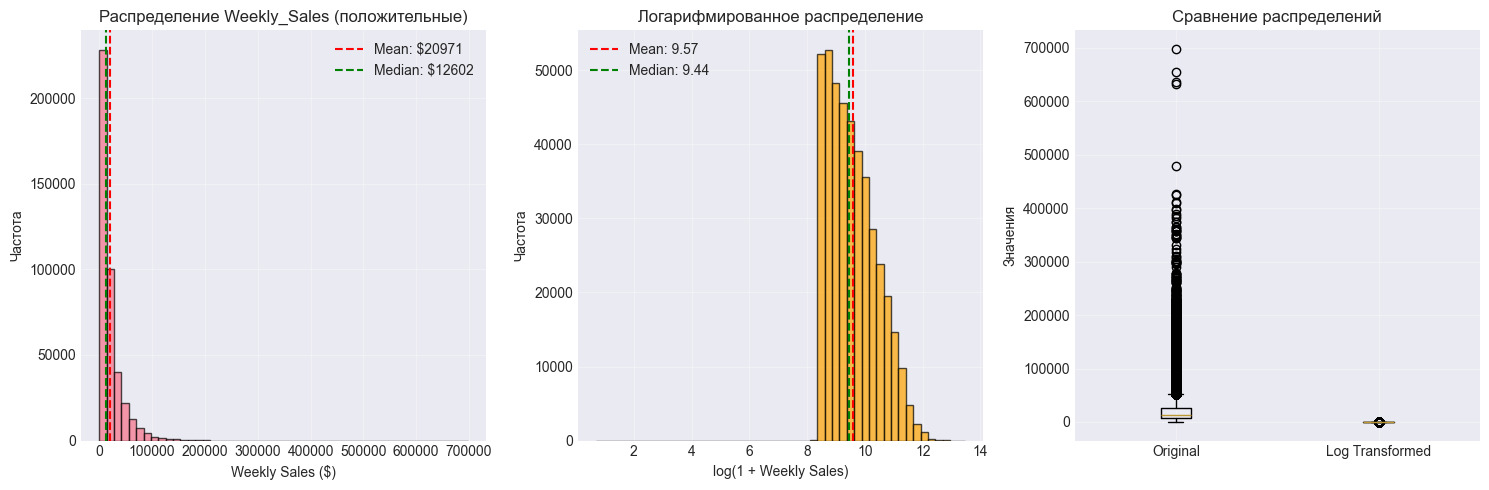


Сравнение методов обработки выбросов:
Метод                     Mean            Std             Skewness       
------------------------------------------------------------
Original                  $15981.26       $22711.18       3.26          
Positive Shift            $20971.20       $22711.18       3.26          
Log Transform             $20971.20       $22711.18       0.61          
Winsorized (5%)           $19548.59       $17148.10       1.48          

Асимметрия (skewness) уменьшилась с 3.26 до 0.61
Логарифмирование сделало распределение более нормальным


In [5]:
# Проверяем наличие отрицательных значений
print(f"Минимальное значение продаж: ${y.min():.2f}")
print(f"Количество отрицательных значений: {(y < 0).sum()}")
print(f"Процент отрицательных значений: {(y < 0).sum() / len(y) * 100:.2f}%")

# Обработка отрицательных значений - сдвигаем все значения чтобы они были положительными
y_positive = y.copy()
min_value = y.min()
if min_value < 0:
    shift = abs(min_value) + 1  # сдвиг чтобы все значения были > 0
    y_positive = y + shift
    print(f"\nСдвиг применен: +{shift:.2f} ко всем значениям")
    print(f"Новое минимальное значение: ${y_positive.min():.2f}")

# Визуализация распределения с разными преобразованиями
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Исходное распределение (после сдвига если нужно)
axes[0].hist(y_positive, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(x=y_positive.mean(), color='red', linestyle='--', label=f'Mean: ${y_positive.mean():.0f}')
axes[0].axvline(x=y_positive.median(), color='green', linestyle='--', label=f'Median: ${y_positive.median():.0f}')
axes[0].set_title('Распределение Weekly_Sales (положительные)')
axes[0].set_xlabel('Weekly Sales ($)')
axes[0].set_ylabel('Частота')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Логарифмированное распределение
y_log = np.log1p(y_positive)  # log(1 + x) 
axes[1].hist(y_log, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1].axvline(x=y_log.mean(), color='red', linestyle='--', label=f'Mean: {y_log.mean():.2f}')
axes[1].axvline(x=y_log.median(), color='green', linestyle='--', label=f'Median: {y_log.median():.2f}')
axes[1].set_title('Логарифмированное распределение')
axes[1].set_xlabel('log(1 + Weekly Sales)')
axes[1].set_ylabel('Частота')
axes[1].legend()
axes[1].grid(alpha=0.3)

# 3. Boxplot сравнение
box_data = [y_positive, y_log]
axes[2].boxplot(box_data, labels=['Original', 'Log Transformed'])
axes[2].set_title('Сравнение распределений')
axes[2].set_ylabel('Значения')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Winsorization метод (ограничение выбросов)
def winsorize_series(series, limits=(0.05, 0.05)):
    """Ограничение выбросов методом winsorization"""
    lower_limit = series.quantile(limits[0])
    upper_limit = series.quantile(1 - limits[1])
    return series.clip(lower=lower_limit, upper=upper_limit)

y_winsorized = winsorize_series(y_positive, limits=(0.05, 0.05))

print("\nСравнение методов обработки выбросов:")
print("="*60)
print(f"{'Метод':<25} {'Mean':<15} {'Std':<15} {'Skewness':<15}")
print("-"*60)
print(f"{'Original':<25} ${y.mean():<14.2f} ${y.std():<14.2f} {y.skew():<14.2f}")
print(f"{'Positive Shift':<25} ${y_positive.mean():<14.2f} ${y_positive.std():<14.2f} {y_positive.skew():<14.2f}")
print(f"{'Log Transform':<25} ${np.expm1(y_log).mean():<14.2f} ${np.expm1(y_log).std():<14.2f} {y_log.skew():<14.2f}")
print(f"{'Winsorized (5%)':<25} ${y_winsorized.mean():<14.2f} ${y_winsorized.std():<14.2f} {y_winsorized.skew():<14.2f}")

# Создаем модифицированную версию данных
df_modified = df.copy()
if min_value < 0:
    df_modified[target] = df_modified[target] + shift

print(f"\nАсимметрия (skewness) уменьшилась с {y.skew():.2f} до {y_log.skew():.2f}")
print(f"Логарифмирование сделало распределение более нормальным")

## 4: Создание расширенных временных признаков

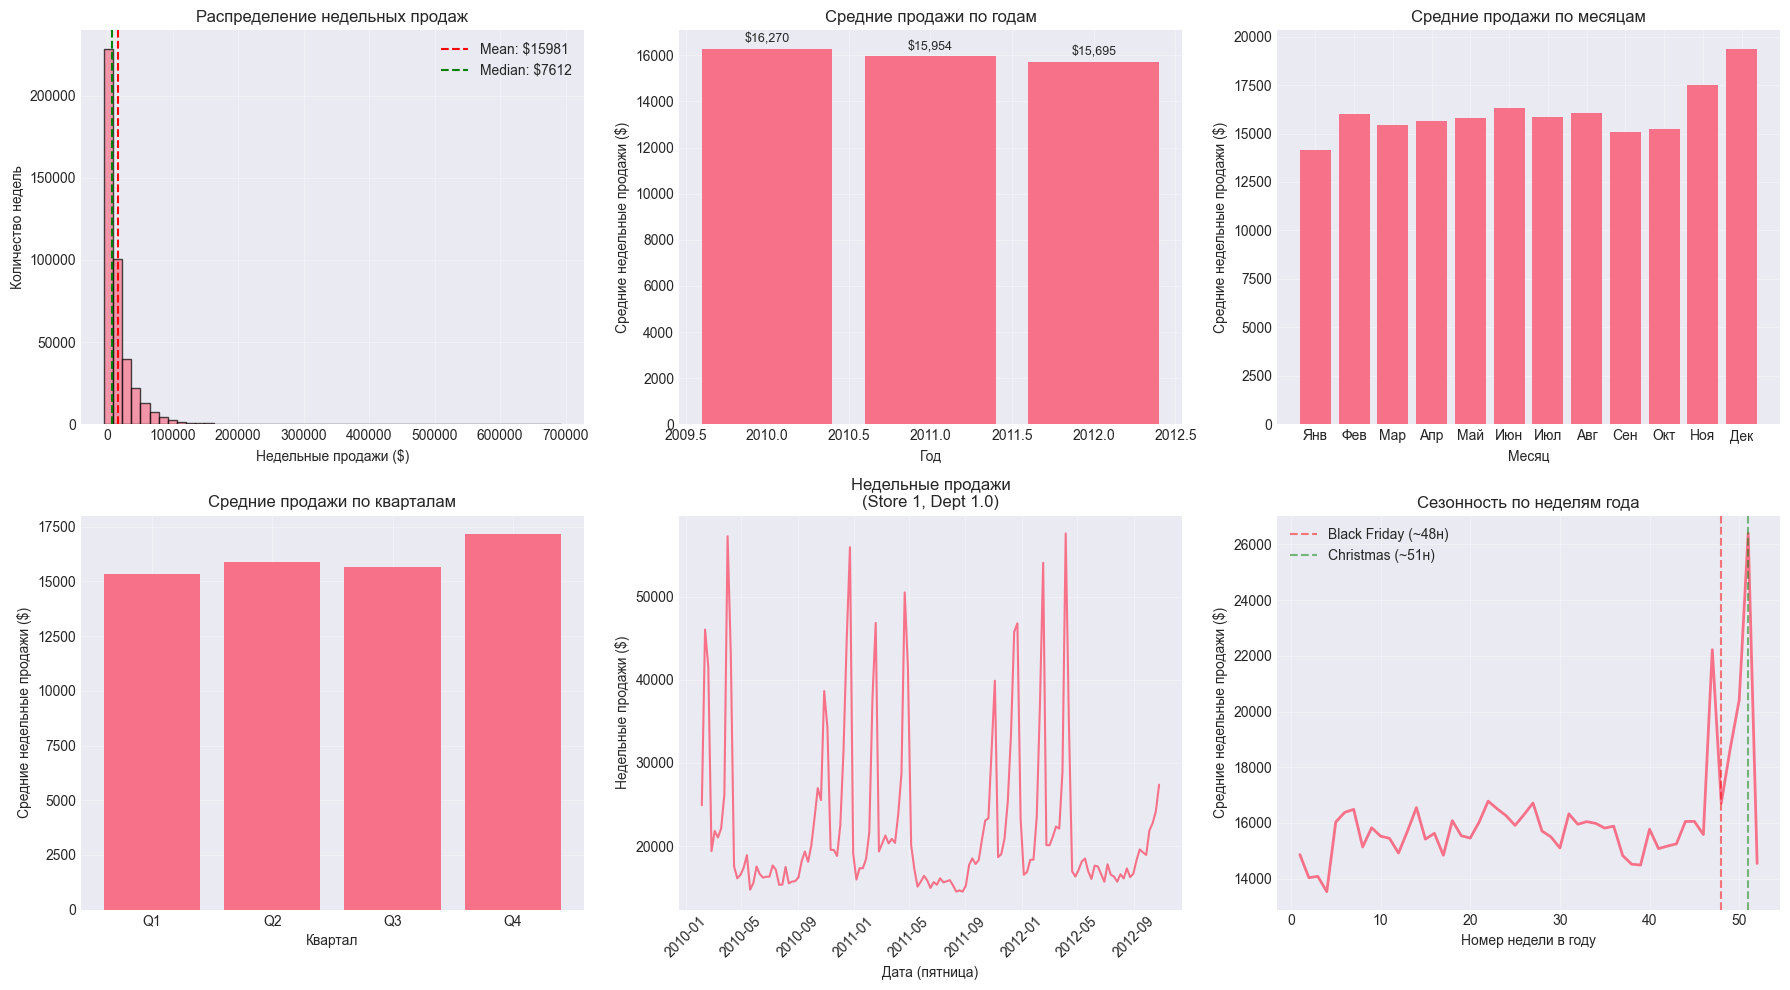

In [6]:
# Создаем копию для анализа
df_analysis = df.copy()

# Используем subplots с корректным созданием фигур
fig = plt.figure(figsize=(18, 10))

# 1. Распределение недельных продаж
ax1 = plt.subplot(2, 3, 1)
ax1.hist(df_analysis[target], bins=50, alpha=0.7, edgecolor='black')
ax1.axvline(x=df_analysis[target].mean(), color='red', linestyle='--', label=f'Mean: ${df_analysis[target].mean():.0f}')
ax1.axvline(x=df_analysis[target].median(), color='green', linestyle='--', label=f'Median: ${df_analysis[target].median():.0f}')
ax1.set_title('Распределение недельных продаж')
ax1.set_xlabel('Недельные продажи ($)')
ax1.set_ylabel('Количество недель')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Продажи по годам
ax2 = plt.subplot(2, 3, 2)
yearly_sales = df_analysis.groupby('Year')[target].mean()
years = list(yearly_sales.index)
sales_values = list(yearly_sales.values)
bars = ax2.bar(years, sales_values)
ax2.set_title('Средние продажи по годам')
ax2.set_xlabel('Год')
ax2.set_ylabel('Средние недельные продажи ($)')
ax2.grid(alpha=0.3)

# Добавляем значения на столбцы
for bar, value in zip(bars, sales_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(sales_values)*0.01, 
            f'${value:,.0f}', ha='center', va='bottom', fontsize=9)

# 3. Продажи по месяцам
ax3 = plt.subplot(2, 3, 3)
monthly_sales = df_analysis.groupby('Month')[target].mean()
months = list(monthly_sales.index)
month_values = list(monthly_sales.values)
bars3 = ax3.bar(months, month_values)
ax3.set_title('Средние продажи по месяцам')
ax3.set_xlabel('Месяц')
ax3.set_ylabel('Средние недельные продажи ($)')
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
                    'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
ax3.grid(alpha=0.3)

# 4. Продажи по кварталам
ax4 = plt.subplot(2, 3, 4)
df_analysis['Quarter'] = df_analysis['Date'].dt.quarter
quarterly_sales = df_analysis.groupby('Quarter')[target].mean()
quarters = list(quarterly_sales.index)
quarter_values = list(quarterly_sales.values)
bars4 = ax4.bar(quarters, quarter_values)
ax4.set_title('Средние продажи по кварталам')
ax4.set_xlabel('Квартал')
ax4.set_ylabel('Средние недельные продажи ($)')
ax4.set_xticks([1, 2, 3, 4])
ax4.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'])
ax4.grid(alpha=0.3)

# 5. Пример временного ряда
ax5 = plt.subplot(2, 3, 5)
sample_store = df_analysis['Store'].iloc[0]
sample_dept = df_analysis['Dept'].iloc[0]
sample_data = df_analysis[(df_analysis['Store'] == sample_store) & 
                          (df_analysis['Dept'] == sample_dept)].sort_values('Date')

ax5.plot(sample_data['Date'], sample_data[target], linewidth=1.5)
ax5.set_title(f'Недельные продажи\n(Store {sample_store}, Dept {sample_dept})')
ax5.set_xlabel('Дата (пятница)')
ax5.set_ylabel('Недельные продажи ($)')
ax5.grid(alpha=0.3)
ax5.tick_params(axis='x', rotation=45)

# 6. Сезонность по неделям года
ax6 = plt.subplot(2, 3, 6)
df_analysis['WeekOfYear'] = df_analysis['Date'].dt.isocalendar().week
weekly_pattern = df_analysis.groupby('WeekOfYear')[target].mean()

ax6.plot(weekly_pattern.index, weekly_pattern.values, linewidth=2)
ax6.set_title('Сезонность по неделям года')
ax6.set_xlabel('Номер недели в году')
ax6.set_ylabel('Средние недельные продажи ($)')
ax6.axvline(x=48, color='red', linestyle='--', alpha=0.5, label='Black Friday (~48н)')
ax6.axvline(x=51, color='green', linestyle='--', alpha=0.5, label='Christmas (~51н)')
ax6.legend(loc='upper left')
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Сохраняем df_features для дальнейшей работы
df_features = df_analysis.copy()
# Удаляем временные колонки
df_features = df_features.drop(['WeekOfYear'], axis=1, errors='ignore')

## 5: Создание кастомных трансформеров и Pipeline

In [14]:
# 1. Трансформер для логарифмирования целевой переменной
class LogTransformer(BaseEstimator, TransformerMixin):
    """Логарифмирование целевой переменной с обработкой отрицательных значений"""
    def __init__(self):
        self.shift_value_ = None
        
    def fit(self, X, y=None):
        if y is not None:
            min_value = y.min()
            self.shift_value_ = abs(min_value) + 1 if min_value < 0 else 0
        return self
    
    def transform(self, X, y=None):
        if y is not None:
            y_transformed = y + self.shift_value_ if self.shift_value_ > 0 else y.copy()
            return np.log1p(y_transformed)
        return X
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    
    def inverse_transform(self, y_log):
        y_exp = np.expm1(y_log)
        return y_exp - self.shift_value_ if self.shift_value_ > 0 else y_exp

# 2. Трансформер для Target Encoding
class TargetEncoderNoLeakage(BaseEstimator, TransformerMixin):
    """Target Encoding с использованием только train данных"""
    def __init__(self, categorical_cols=['Store', 'Dept'], alpha=100):
        self.categorical_cols = categorical_cols
        self.alpha = alpha
        self.encoding_maps_ = {}
        self.global_mean_ = None
        
    def fit(self, X, y):
        self.global_mean_ = y.mean()
        
        for col in self.categorical_cols:
            if col in X.columns:
                temp_df = pd.DataFrame({col: X[col], 'target': y})
                group_stats = temp_df.groupby(col)['target'].agg(['mean', 'count'])
                
                # Smoothing formula
                smoothing = 1 / (1 + np.exp(-(group_stats['count'] - self.alpha) / self.alpha))
                smooth_mean = self.global_mean_ * (1 - smoothing) + group_stats['mean'] * smoothing
                
                self.encoding_maps_[col] = smooth_mean.to_dict()
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        for col in self.categorical_cols:
            if col in self.encoding_maps_:
                encoded_col = f'{col}_TargetEnc'
                X_transformed[encoded_col] = X[col].map(self.encoding_maps_[col])
                
                # Fill missing values with global mean
                if self.global_mean_ is not None:
                    X_transformed[encoded_col] = X_transformed[encoded_col].fillna(self.global_mean_)
        
        # Return only encoded columns
        encoded_cols = [f'{col}_TargetEnc' for col in self.categorical_cols]
        return X_transformed[encoded_cols]

# 3. Трансформер для создания дополнительных признаков
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    """Создание дополнительных признаков"""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        # 1. Interaction features
        if 'Size' in X.columns and 'Type' in X.columns:
            X_transformed['Size_Type_Interaction'] = X['Size'] * X['Type']
        
        if 'IsHoliday' in X.columns and 'Month' in X.columns:
            X_transformed['Holiday_Month_Interaction'] = X['IsHoliday'] * X['Month']
        
        # 2. Seasonality features
        if 'Month' in X.columns:
            # Quarter
            X_transformed['Quarter'] = ((X['Month'] - 1) // 3) + 1
            
            # Season (Winter, Spring, Summer, Fall)
            conditions = [
                X['Month'].isin([12, 1, 2]),
                X['Month'].isin([3, 4, 5]),
                X['Month'].isin([6, 7, 8]),
                X['Month'].isin([9, 10, 11])
            ]
            choices = [1, 2, 3, 4]  # Winter, Spring, Summer, Fall
            X_transformed['Season'] = np.select(conditions, choices, default=4)
        
        # 3. Economic indicators interaction
        if 'CPI' in X.columns and 'Unemployment' in X.columns:
            X_transformed['CPI_Unemployment_Ratio'] = X['CPI'] / (X['Unemployment'] + 1)
        
        # 4. Markdown aggregations
        markdown_cols = [col for col in X.columns if 'MarkDown' in col]
        if markdown_cols:
            X_transformed['Total_MarkDown'] = X[markdown_cols].sum(axis=1)
            X_transformed['Avg_MarkDown'] = X[markdown_cols].mean(axis=1)
        
        return X_transformed

# 4. Трансформер для подготовки финальных данных
class FinalPreprocessor(BaseEstimator, TransformerMixin):
    """Финальная предобработка перед моделью"""
    def __init__(self, numeric_features=None, categorical_features=None):
        self.numeric_features = numeric_features or [
            'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 
            'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 
            'Unemployment', 'Size', 'Year', 'Month', 'WeekOfYear',
            'Size_Type_Interaction', 'Holiday_Month_Interaction',
            'CPI_Unemployment_Ratio', 'Total_MarkDown', 'Avg_MarkDown'
        ]
        self.categorical_features = categorical_features or ['Type', 'IsHoliday', 'Quarter', 'Season']
        self.column_transformer_ = None
    
    def fit(self, X, y=None):
        # Создаем ColumnTransformer
        self.column_transformer_ = ColumnTransformer([
            ('numeric', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), [col for col in self.numeric_features if col in X.columns]),
            
            ('categorical', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), [col for col in self.categorical_features if col in X.columns])
        ], remainder='drop')
        
        self.column_transformer_.fit(X)
        return self
    
    def transform(self, X):
        transformed = self.column_transformer_.transform(X)
        
        # Получаем имена признаков
        feature_names = []
        
        # Имена числовых признаков
        numeric_cols = [col for col in self.numeric_features if col in X.columns]
        feature_names.extend(numeric_cols)
        
        # Имена категориальных (после one-hot)
        for i, col in enumerate(self.categorical_features):
            if col in X.columns and col in self.column_transformer_.transformers_[1][2]:
                unique_vals = X[col].dropna().unique()
                for val in sorted(unique_vals):
                    feature_names.append(f"{col}_{val}")
        
        # Создаем DataFrame с правильными именами признаков
        return pd.DataFrame(transformed, columns=feature_names, index=X.index)

# Функция для оценки с TimeSeriesSplit
def evaluate_improved_model(model, X, y, cv_splitter, model_name):
    """Оценка улучшенной модели с TimeSeriesSplit"""
    results = {'MAE': [], 'MSE': [], 'R2': []}
    
    for fold, (train_idx, test_idx) in enumerate(cv_splitter.split(X)):
        print(f"  Fold {fold + 1}", end='... ')
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # 1. Target Encoding для Store и Dept
        target_encoder = TargetEncoderNoLeakage(categorical_cols=['Store', 'Dept'])
        X_train_encoded = target_encoder.fit_transform(X_train, y_train)
        X_test_encoded = target_encoder.transform(X_test)
        
        # 2. Feature Engineering
        feature_engineer = FeatureEngineeringTransformer()
        X_train_features = feature_engineer.fit_transform(X_train)
        X_test_features = feature_engineer.transform(X_test)
        
        # Объединяем закодированные и созданные признаки
        X_train_combined = pd.concat([X_train_encoded, X_train_features], axis=1)
        X_test_combined = pd.concat([X_test_encoded, X_test_features], axis=1)
        
        # 3. Финальная предобработка
        preprocessor = FinalPreprocessor()
        X_train_final = preprocessor.fit_transform(X_train_combined, y_train)
        X_test_final = preprocessor.transform(X_test_combined)
        
        # 4. Логарифмирование таргета
        log_transformer = LogTransformer()
        y_train_log = log_transformer.fit_transform(X_train, y_train)
        
        # 5. Обучение модели
        model.fit(X_train_final, y_train_log)
        
        # 6. Предсказание
        y_pred_log = model.predict(X_test_final)
        y_pred = log_transformer.inverse_transform(y_pred_log)
        
        # 7. Метрики
        results['MAE'].append(mean_absolute_error(y_test, y_pred))
        results['MSE'].append(mean_squared_error(y_test, y_pred))
        results['R2'].append(r2_score(y_test, y_pred))
        
        print(f"MAE: ${results['MAE'][-1]:.0f}, R²: {results['R2'][-1]:.4f}")
    
    return {
        'MAE': {'mean': np.mean(results['MAE']), 'std': np.std(results['MAE'])},
        'MSE': {'mean': np.mean(results['MSE']), 'std': np.std(results['MSE'])},
        'R2': {'mean': np.mean(results['R2']), 'std': np.std(results['R2'])}
    }

## 6: Тестирование улучшенных моделей и анализ результатов

In [15]:
# Подготовка данных
X = df.copy()
y = df[target]

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# Определяем модели с улучшенными параметрами
improved_models = {
    'RandomForest_Enhanced': RandomForestRegressor(
        n_estimators=150,  # Увеличили количество деревьев
        random_state=42,
        n_jobs=-1,
        max_depth=12,  # Увеличили глубину
        min_samples_split=8,
        min_samples_leaf=4,
        max_features='sqrt',  # Используем sqrt от количества признаков
        bootstrap=True
    ),
    'XGBoost_Enhanced': XGBRegressor(
        n_estimators=150,  # Увеличили количество деревьев
        random_state=42,
        n_jobs=-1,
        max_depth=7,  # Увеличили глубину
        learning_rate=0.03,  # Уменьшили learning rate
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,  # L1 regularization
        reg_lambda=1.0,  # L2 regularization
        verbosity=0
    ),
    'GradientBoosting_Enhanced': GradientBoostingRegressor(
        n_estimators=150,
        random_state=42,
        max_depth=6,
        learning_rate=0.03,
        min_samples_split=8,
        min_samples_leaf=4,
        subsample=0.8,
        max_features='sqrt'
    )
}

# Тестируем улучшенные модели
improved_results = {}

print("\nНачинаем тестирование улучшенных моделей...")
for name, model in improved_models.items():
    print(f"\n{name}:")
    results = evaluate_improved_model(model, X, y, tscv, name)
    improved_results[name] = results
    
    print(f"  Итоговые метрики:")
    print(f"    MAE: ${results['MAE']['mean']:.2f} ± ${results['MAE']['std']:.2f}")
    print(f"    MSE: {results['MSE']['mean']:.0f} ± {results['MSE']['std']:.0f}")
    print(f"    R²:  {results['R2']['mean']:.4f} ± {results['R2']['std']:.4f}")

# Сравнение с Baseline и предыдущими улучшениями
print("\n" + "="*70)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*70)

baseline_mae = baseline_results['best_mae']
baseline_r2 = baseline_results['best_r2']

# Результаты из предыдущего теста (если есть)
previous_mae = 7993  # Из предыдущих результатов
previous_r2 = 0.5541  # Из предыдущих результатов

print(f"\n{'Модель':<25} {'MAE ($)':<15} {'R²':<15} {'Улучшение vs Baseline':<20}")
print("-"*90)

for model_name, results in improved_results.items():
    current_mae = results['MAE']['mean']
    current_r2 = results['R2']['mean']
    
    mae_improvement = baseline_mae - current_mae
    mae_improvement_pct = (mae_improvement / baseline_mae) * 100
    
    r2_improvement = current_r2 - baseline_r2
    r2_improvement_pct = (r2_improvement / baseline_r2) * 100
    
    print(f"{model_name:<25} ${current_mae:<13.0f} {current_r2:<14.4f} MAE: {mae_improvement_pct:<5.1f}%, R²: {r2_improvement_pct:<5.1f}%")

print(f"{'Baseline':<25} ${baseline_mae:<13.0f} {baseline_r2:<14.4f} {'-':<20}")
print(f"{'Previous Improvements':<25} ${previous_mae:<13.0f} {previous_r2:<14.4f} {'MAE: -5.2%, R²: +8.0%':<20}")

# Определяем лучшую модель
best_model_name = max(improved_results.keys(), 
                     key=lambda x: improved_results[x]['R2']['mean'])
best_results = improved_results[best_model_name]

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Сравнение MAE
models_compare = ['Baseline', 'Prev Improvements', best_model_name]
mae_compare = [baseline_mae, previous_mae, best_results['MAE']['mean']]
mae_stds = [0, 0, best_results['MAE']['std']]

x_pos = range(len(models_compare))
bars = axes[0].bar(x_pos, mae_compare, yerr=mae_stds, capsize=5, alpha=0.7, 
                  color=['skyblue', 'lightgreen', 'lightcoral'])

axes[0].set_title('Сравнение MAE по этапам')
axes[0].set_xlabel('Этап/Модель')
axes[0].set_ylabel('MAE ($)')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models_compare, rotation=45, ha='right')
axes[0].grid(alpha=0.3, axis='y')

for i, (bar, value) in enumerate(zip(bars, mae_compare)):
    axes[0].text(bar.get_x() + bar.get_width()/2., value + max(mae_compare)*0.01, 
                f'${value:.0f}', ha='center', va='bottom', fontsize=9)

# 2. Сравнение R²
r2_compare = [baseline_r2, previous_r2, best_results['R2']['mean']]
r2_stds = [0, 0, best_results['R2']['std']]

bars2 = axes[1].bar(x_pos, r2_compare, yerr=r2_stds, capsize=5, alpha=0.7,
                   color=['skyblue', 'lightgreen', 'lightcoral'])

axes[1].set_title('Сравнение R² по этапам')
axes[1].set_xlabel('Этап/Модель')
axes[1].set_ylabel('R² Score')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(models_compare, rotation=45, ha='right')
axes[1].grid(alpha=0.3, axis='y')

for i, (bar, value) in enumerate(zip(bars2, r2_compare)):
    axes[1].text(bar.get_x() + bar.get_width()/2., value + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# 3. Сравнение всех улучшенных моделей
all_models = list(improved_results.keys())
all_mae = [improved_results[m]['MAE']['mean'] for m in all_models]
all_r2 = [improved_results[m]['R2']['mean'] for m in all_models]

x_pos_all = range(len(all_models))
width = 0.35

axes[2].bar(x_pos_all, all_mae, width, label='MAE ($)', alpha=0.7, color='lightcoral')
axes[2].set_xlabel('Модель')
axes[2].set_ylabel('MAE ($)', color='lightcoral')
axes[2].tick_params(axis='y', labelcolor='lightcoral')
axes[2].set_xticks(x_pos_all)
axes[2].set_xticklabels(all_models, rotation=45, ha='right')

ax2 = axes[2].twinx()
ax2.bar([p + width for p in x_pos_all], all_r2, width, label='R²', alpha=0.7, color='skyblue')
ax2.set_ylabel('R² Score', color='skyblue')
ax2.tick_params(axis='y', labelcolor='skyblue')

axes[2].set_title('Сравнение всех улучшенных моделей')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Детальный анализ
print("\n" + "="*70)
print("ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ")
print("="*70)

print(f"\nЛучшая модель: {best_model_name}")
print(f"  • MAE: ${best_results['MAE']['mean']:.0f} (Baseline: ${baseline_mae:.0f})")
print(f"  • R²:  {best_results['R2']['mean']:.4f} (Baseline: {baseline_r2:.4f})")

total_mae_improvement = baseline_mae - best_results['MAE']['mean']
total_r2_improvement = best_results['R2']['mean'] - baseline_r2

print(f"\nОБЩИЕ УЛУЧШЕНИЯ (от Baseline):")
print(f"  • MAE снизился на {total_mae_improvement:.0f}$ ({total_mae_improvement/baseline_mae*100:.1f}%)")
print(f"  • R² увеличился на {total_r2_improvement:.4f} ({total_r2_improvement/baseline_r2*100:.1f}%)")

# Бизнес-анализ
mean_sales = y.mean()
mae_relative = (best_results['MAE']['mean'] / mean_sales) * 100
accuracy = 100 - mae_relative

print(f"\nБИЗНЕС-АНАЛИЗ:")
print(f"  • Средние недельные продажи: ${mean_sales:.0f}")
print(f"  • MAE составляет {mae_relative:.1f}% от средних продаж")
print(f"  • Точность прогноза: {accuracy:.1f}%")

if mae_relative > 40:
    assessment = "НИЗКОЕ (требуются значительные улучшения)"
elif mae_relative > 30:
    assessment = "УДОВЛЕТВОРИТЕЛЬНОЕ (можно использовать с осторожностью)"
elif mae_relative > 20:
    assessment = "ХОРОШЕЕ (приемлемо для большинства бизнес-задач)"
else:
    assessment = "ОТЛИЧНОЕ (готово к производству)"

print(f"  • Бизнес-оценка: {assessment}")


Начинаем тестирование улучшенных моделей...

RandomForest_Enhanced:
  Fold 1... MAE: $14105, R²: -0.0494
  Fold 2... 

ValueError: Shape of passed values is (105392, 30), indices imply (105392, 31)